#### Import libraries

In [1]:
pip install mord

You are using pip version 9.0.3, however version 20.0.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import mord as md
import pandas as pd
import numpy as np
from sklearn import metrics
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

#### Define ordered logistic functions

In [3]:
def OL_summary_output(model):
    
    #Computes coefficients
    params = model.coef_
    
    #Computes predictions
    prediction = model.predict(x)

    #Computes metrics
    MSE = metrics.mean_squared_error(y, prediction)

    #Creates summary dataframe
    coeff_df = pd.DataFrame(params, x.columns, columns=['Coefficient'])

    #Computes variance
    var_b = MSE*(np.linalg.inv(np.dot(x.T,x)).diagonal())

    #Computes standard error
    sd_b = np.sqrt(var_b)

    #Computes t-statistic
    ts_b = params/sd_b

    #Computes p-values
    p_values =[2*(1-stats.t.cdf(np.abs(i),(len(x)-1))) for i in ts_b]

    #Computes confidence intervals
    conf_int_inf = params - 1.96*sd_b
    conf_int_sup = params + 1.96*sd_b

    #Formats numbers for table
    sd_b = sd_b
    ts_b = np.round(ts_b,3)
    p_values = np.round(p_values,3)
    params = np.round(params,4)

    #Summarizes dataframe
    coeff_df["Standard Errors"],coeff_df["t values"],coeff_df["Probabilites"], coeff_df['2.5%'], coeff_df['97.5%'] = [sd_b,ts_b,p_values, conf_int_inf, conf_int_sup]
    
    return coeff_df

def odds_ratio_summary_output(model_summary_output):
    
    model_summary_output = OL_summary_output(model_ordinal)
    coeff_OR = model_summary_output.copy()
    
    coeff_OR["Coefficient"] = np.exp(model_summary_output["Coefficient"])
    coeff_OR["Standard Errors"] = np.exp(model_summary_output["Standard Errors"])
    coeff_OR['2.5%'] = np.exp(coeff_OR['2.5%'])
    coeff_OR['97.5%'] = np.exp(coeff_OR['97.5%'])
    
    return coeff_OR

#### Read data

In [4]:
data = pd.read_csv('chis_data.csv')
data.head()

,soda_per_week,fast_food,monthly_earnings,homeowner,acc_produce,health_status,acc_produce_ALWAYS,acc_produce_NEVER,acc_produce_SOMETIMES,acc_produce_USUALLY,health_status_recode
0,1.0,2.0,5000.0,1,3,EXCELLENT,0,0,0,1,1
1,1.0,1.0,0.0,0,4,GOOD,1,0,0,0,2
2,21.0,2.0,3000.0,1,4,EXCELLENT,1,0,0,0,1
3,0.0,1.0,2000.0,1,4,GOOD,1,0,0,0,2
4,1.0,3.0,0.0,0,4,VERY GOOD,1,0,0,0,1


In [5]:
data.groupby(by = ['health_status', 'health_status_recode']).size()

health_status  health_status_recode
EXCELLENT      1                       2074
FAIR           2                       1297
GOOD           2                       3158
POOR           3                        201
VERY GOOD      1                       3295
dtype: int64

### Ordinal Logit Regression

#### Define dependent & independent variables

In [6]:
ind_vars = ['soda_per_week', 'fast_food', 'monthly_earnings', 'homeowner',
            'acc_produce_SOMETIMES', 'acc_produce_USUALLY', 'acc_produce_ALWAYS'] ### Baseline is NEVER

y = data['health_status_recode']
x = data[ind_vars]

##### Run the model

In [7]:
model_ordinal = md.LogisticAT().fit(x, y)

##### Model statistics output

In [8]:
OL_summary_output(model_ordinal)

,Coefficient,Standard Errors,t values,Probabilites,2.5%,97.5%
soda_per_week,0.022084,0.001334,16.549,0.00,0.019468,0.024699
fast_food,0.072485,0.002865,25.296,0.00,0.066869,0.078101
monthly_earnings,-0.000038,0.000001,-31.945,0.00,-0.000040,-0.000035
homeowner,-0.416261,0.013473,-30.895,0.00,-0.442669,-0.389853
acc_produce_SOMETIMES,-0.059042,0.025461,-2.319,0.02,-0.108945,-0.009140
acc_produce_USUALLY,-0.171437,0.021688,-7.905,0.00,-0.213946,-0.128929
acc_produce_ALWAYS,-0.512261,0.012671,-40.428,0.00,-0.537096,-0.487425


In [9]:
odds_ratio_summary_output(model_ordinal)

,Coefficient,Standard Errors,t values,Probabilites,2.5%,97.5%
soda_per_week,1.022330,1.001335,16.549,0.00,1.019659,1.025007
fast_food,1.075177,1.002870,25.296,0.00,1.069155,1.081232
monthly_earnings,0.999962,1.000001,-31.945,0.00,0.999960,0.999965
homeowner,0.659508,1.013565,-30.895,0.00,0.642320,0.677156
acc_produce_SOMETIMES,0.942667,1.025788,-2.319,0.02,0.896779,0.990902
acc_produce_USUALLY,0.842453,1.021925,-7.905,0.00,0.807392,0.879037
acc_produce_ALWAYS,0.599140,1.012752,-40.428,0.00,0.584443,0.614206


#### Predicted probabilities

In [10]:
exc, good, poor = zip(*model_ordinal.predict_proba(x))

df_predict = data.copy()
df_predict['pred_exc'], df_predict['pred_good'], df_predict['pred_poor'] = exc, good, poor

###### Categorical variable

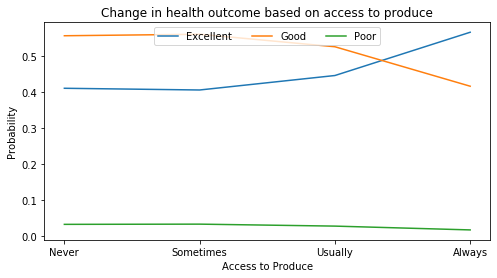

In [12]:
# Aggregate data by access to produce and compute the mean of the probability
df_predict_plot = df_predict.groupby(by = 'acc_produce').agg(np.mean)[['pred_exc', 'pred_good', 'pred_poor']]

df_predict_plot.plot(figsize = (8,4))
+
positions = (1, 2, 3, 4)
labels = ('Never', 'Sometimes', 'Usually', 'Always')
plt.xticks(positions, labels)

plt.xlabel ('Access to Produce')
plt.ylabel ('Probability')
plt.title ('Change in health outcome based on access to produce')

lab = ('Excellent', 'Good', 'Poor')
plt.legend(loc='upper center', ncol=3, labels = lab);

##### Continous variable

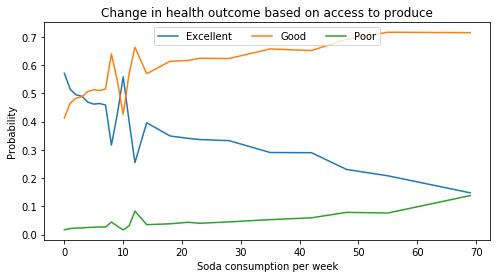

In [13]:
x = 'soda_per_week'
y = ['pred_exc', 'pred_good', 'pred_poor']

df_predict_plot = df_predict.groupby(by = x).agg(np.mean)[y].reset_index()

df_predict_plot.plot(x, y, figsize = (8,4));

plt.xlabel ('Soda consumption per week')
plt.ylabel ('Probability')
plt.title ('Change in health outcome based on access to produce')

lab = ('Excellent', 'Good', 'Poor')
plt.legend(loc='upper center', ncol=3, labels = lab);